<a href="https://colab.research.google.com/github/quangly/MovieRecommendation/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Description: Build a movie recommendation engine using Python

In [2]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display in Colab instead of Jupyter
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

from pprint import pprint as pp

import pickle

In [3]:
#Load the data
from google.colab import files
uploaded = files.upload()

Saving imdb_top_1000.csv to imdb_top_1000.csv


In [4]:
#source https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
df = pd.read_csv("imdb_top_1000.csv")
df['Movie_id'] = range(0,1000)
# shift column 'Name' to first position
first_column = df.pop('Movie_id')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(0, 'Movie_id', first_column)
#rename column Category to Genre
df = df.rename(columns={"Category": "Genre"})
df = df.rename(columns={"Series_Title": "Title"})
df.head(3)



,Movie_id,Poster_Link,Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


In [5]:
#get count of numbr of row/smovies in the data set and number of columns
df.shape

(1000, 17)

In [6]:
#create list of important columns for the recommendation engine
columns = ['Director', 'Star1','Star2','Star3','Star4','Genre','Title']

In [7]:
#show the data
df[columns].head(3)

,Director,Star1,Star2,Star3,Star4,Genre,Title
0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Drama,The Shawshank Redemption
1,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"Crime, Drama",The Godfather
2,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"Action, Crime, Drama",The Dark Knight


In [8]:
#check for any missing values in the import columns
df[columns].isnull().values.any()
df.columns[df.isna().any()].tolist()
# df.loc[:, df.isnull().any()]

['Certificate', 'Meta_score', 'Gross']

In [9]:
# create a function to combine the values of the import columns into a single string
def get_important_features(df):
  important_features = []
  for i in range(0,df.shape[0]):
    important_features.append(df['Star1'][i] + \
                              ' ' + df['Star2'][i] + \
                              ' ' + df['Star3'][i] + \
                              ' ' + df['Star4'][i] + \
                              ' ' + df['Director'][i] + \
                              ' ' + df['Title'][i] + \
                              ' ' + df['Genre'][i])
  
  return important_features

In [10]:
#create a column to hold the combined strings
df['important_features'] = get_important_features(df)
# #show the data
# pd.set_option('display.max_rows', None)
# # df['important_features'].unique()
# df.head(3)

In [11]:
# convert the text to a matrix of token counts
# https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c
cm = CountVectorizer().fit_transform(df['important_features'])

In [12]:
#get the cosine simimlarity matrix from the count matrix
cs = cosine_similarity(cm)
#Print the cosine similarity matrix - values 0 to 1. 1 = 100% similar to a movie
#each row is a movie and each column is a movie.
#first row/column is 1 b/c it's a movie similar to itself
# print(cs)
#get the shape of the cosine similarity matrix
# cs.shape

In [13]:
#create a list of enumerations for the similarity score [(movie_id, similarity score), (..)]
def get_movie_scores(movie_id):
  scores = list(enumerate(cs[movie_id]))
  #Sort the list x[1] = similarity score descending score
  sorted_scores = sorted(scores, key = lambda x:x[1], reverse = True)
  #get every element exempt first element
  sorted_scores = sorted_scores[1:]
  return sorted_scores

#get list of unique movie id
movie_ids = df['Movie_id'].unique().tolist()
movie_score_list = []
for movie_id in movie_ids:
  movie_score_list.append({"movie_id": movie_id,
                           "sorted_scores": get_movie_scores(movie_id)})


# create model that includes dataframe and movie_score_list
model = dict()
model["df"] = df
model["movie_score_list"] = movie_score_list

In [14]:
# export using pickle
with open('model_movie_score_list.pkl', 'wb') as fid:
     pickle.dump(model, fid)

In [15]:
# Read the data from the pickled file
with open('model_movie_score_list.pkl', 'rb') as fid:
     model_movie_score_list = pickle.load(fid)

In [16]:
#get list of unique movie names
df = model_movie_score_list["df"]
movie_score_list = model_movie_score_list["movie_score_list"]
print(list(df['Title'].unique()))

['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'The Godfather: Part II', '12 Angry Men', 'The Lord of the Rings: The Return of the King', 'Pulp Fiction', "Schindler's List", 'Inception', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Ring', 'Forrest Gump', 'Il buono, il brutto, il cattivo', 'The Lord of the Rings: The Two Towers', 'The Matrix', 'Goodfellas', 'Star Wars: Episode V - The Empire Strikes Back', "One Flew Over the Cuckoo's Nest", 'Hamilton', 'Gisaengchung', 'Soorarai Pottru', 'Interstellar', 'Cidade de Deus', 'Sen to Chihiro no kamikakushi', 'Saving Private Ryan', 'The Green Mile', 'La vita è bella', 'Se7en', 'The Silence of the Lambs', 'Star Wars', 'Seppuku', 'Shichinin no samurai', "It's a Wonderful Life", 'Joker', 'Whiplash', 'The Intouchables', 'The Prestige', 'The Departed', 'The Pianist', 'Gladiator', 'American History X', 'The Usual Suspects', 'Léon', 'The Lion King', 'Terminator 2: Judgment Day', 'Nuovo Cinema Paradiso', 'Hotaru no hak

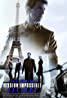

Mission: Impossible - Fallout None

The related recommended movies are:
********************


In [53]:
#get the title of the movie that user likes
# "The Dark Knight" "Scarface" "Pulp Fiction" "Inception" "The Silence of the Lambs" "The Hangover" "Mission: Impossible - Fallout"
title = "Mission: Impossible - Fallout"

try:
  #find the movies id
  movie_id = df[df.Title == title]['Movie_id'].values[0]

  #get metadata
  movie_title = df[df.Movie_id == movie_id]['Title'].values[0]
  poster_url = df[df.Movie_id == movie_id]['Poster_Link'].values[0]
  image = io.imread(poster_url) 
  print("{movie_title} {image}".format(movie_title=movie_title, image=cv2_imshow(image)))

  print('\nThe related recommended movies are:')
  print('*'*20)

  #get sorted scores based on movie_id from trained movie_score_list
  sorted_scores = next(item["sorted_scores"] for item in movie_score_list if item["movie_id"] == movie_id)

  #get related movies 10 or less. some sorted_scores for a movie contain less than 10
  limit = min(len(sorted_scores), 10)
  results = list()
  for item in sorted_scores[:limit]:
    meta = dict()
    movie_title = df[df.Movie_id == item[0]]['Title'].values[0]
    poster_url = df[df.Movie_id == item[0]]['Poster_Link'].values[0]
    overview = df[df.Movie_id == item[0]]['Overview'].values[0]
    meta["movie_title"] = movie_title
    meta["poster_url"] = poster_url
    meta["overview"] = overview
    results.append(meta)

except:
  print("\nSorry, {title} had an issue finding related programs".format(title=title))

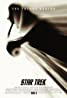

1: Star Trek None The brash James T. Kirk tries to live up to his father's legacy with Mr. Spock keeping him in check as a vengeful Romulan from the future creates black holes to destroy the Federation one planet at a time.


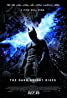

1: The Dark Knight Rises None Eight years after the Joker's reign of anarchy, Batman, with the help of the enigmatic Catwoman, is forced from his exile to save Gotham City from the brutal guerrilla terrorist Bane.


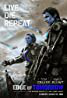

1: Edge of Tomorrow None A soldier fighting aliens gets to relive the same day over and over again, the day restarting every time he dies.


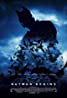

1: Batman Begins None After training with his mentor, Batman begins his fight to free crime-ridden Gotham City from corruption.


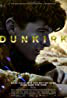

1: Dunkirk None Allied soldiers from Belgium, the British Empire, and France are surrounded by the German Army and evacuated during a fierce battle in World War II.


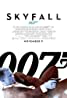

1: Skyfall None James Bond's loyalty to M is tested when her past comes back to haunt her. When MI6 comes under attack, 007 must track down and destroy the threat, no matter how personal the cost.


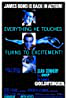

1: Goldfinger None While investigating a gold magnate's smuggling, James Bond uncovers a plot to contaminate the Fort Knox gold reserve.


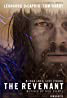

1: The Revenant None A frontiersman on a fur trading expedition in the 1820s fights for survival after being mauled by a bear and left for dead by members of his own hunting team.


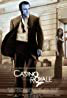

1: Casino Royale None After earning 00 status and a licence to kill, Secret Agent James Bond sets out on his first mission as 007. Bond must defeat a private banker funding terrorists in a high-stakes game of poker at Casino Royale, Montenegro.


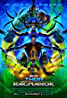

1: Thor: Ragnarok None Imprisoned on the planet Sakaar, Thor must race against time to return to Asgard and stop Ragnarök, the destruction of his world, at the hands of the powerful and ruthless villain Hela.


In [49]:
#Presentation Logic
j = 0
for item in results:
  movie_title = item["movie_title"]
  overview = item["overview"]
  image = io.imread(item["poster_url"])
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat(image, image_2)
  print(str(j+1) + ':', movie_title, cv2_imshow(image), overview)
  

In [ ]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0  67671      0 --:--:-- --:--:-- --:--:-- 67671


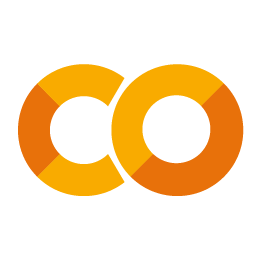

In [40]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)